# Group Details
## Group Name:
### Student 1: Johan van Dongen
### Student 2:
### Student 3:

In [347]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import os

In [348]:
def load_trajectory(filename, task):

    traj = np.load(filename)
    if task == 'task_1' or task == 'task_2':
        trajectory = traj['trajectory']
        energy = traj['energy']
        return trajectory, energy
    if task == 'task_3':
        trajectory = traj['trajectory']
        framework = traj['framework']
        energy = traj['energy']
        return trajectory, framework, energy

# Data Exploration

Below, you can find an example of how to load a trajectory. ```trajectory``` contains the particle position, velocity and charge data. ```energy``` contains the energy of the system at various timesteps. The shape of the arrays is as follows:

```trajectory```: ```(time, n_bodies, [x, y, v_x, v_y, q])```

```energy```: ```(time, 1)```

In [568]:
trajectory, energy = load_trajectory('data/task1_2/test/trajectory_975.npz', 'task_1')
print(f'Trajectory shape: {trajectory.shape}, Energy shape: {energy.shape}')
# 40 steps - 4 trajectories - 5 inputs (x, y, vx, vy, q)

Trajectory shape: (40, 4, 5), Energy shape: (40, 1)


The following code provides an example of how to visualize a trajectory. Feel free to modify this code, or write your own function. When evaluating your model in task 2 and 3, keep in mind that you are only allowed to use the data at t=0 (the black dots in the visualization).

In [581]:
# print(trajectory[0])
traj = [step.flatten() for step in trajectory]
# print(trajectory)
print([t[0][-1] for t in trajectory])
# traj = torch.tensor(traj)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


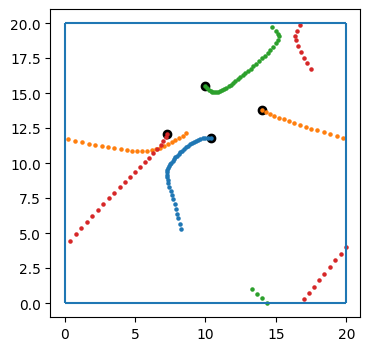

In [569]:
def plot_path(trajectory):
    x = trajectory[...,0]
    y = trajectory[...,1]
    plt.figure(figsize=(4,4))
    plt.vlines([0,20],0,20)
    plt.hlines([0,20],0,20)

    plt.scatter(x[0], y[0], c='black')

    for i in range(x.shape[1]):
        plt.scatter(x[:,i], y[:,i], s=5)

    plt.xlim(-1,21)
    plt.ylim(-1,21)
plot_path(trajectory)

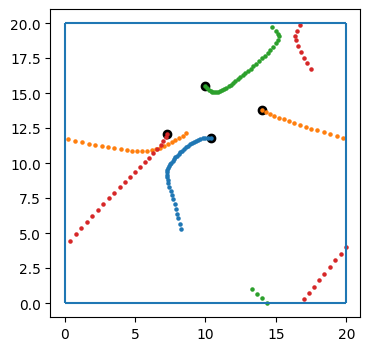

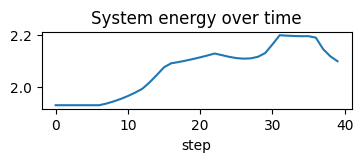

In [570]:


x = trajectory[...,0]
y = trajectory[...,1]

plt.figure(figsize=(4,4))
plt.vlines([0,20],0,20)
plt.hlines([0,20],0,20)

plt.scatter(x[0], y[0], c='black')

for i in range(x.shape[1]):
    plt.scatter(x[:,i], y[:,i], s=5)

plt.xlim(-1,21)
plt.ylim(-1,21)

plt.show()
plt.figure(figsize=(4,1))
plt.plot(energy)
plt.xlabel('step')
plt.title('System energy over time')
plt.show();

# Task 1

In [349]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create Dataset

In [8]:
class TrajectoryDataset(Dataset):
    def __init__(self, train=True):
        type = "train" if train else "test"
        trajectories = []
        energies = []
        files = os.listdir('data/task1_2/' + type)
        for file in tqdm(files):
            if ".npz" in file:
                trajectory, energy = load_trajectory('data/task1_2/' + type + "/" + file, 'task_1')
                trajectories.append(trajectory)
                energies.append(energy)
        # self.x = torch.tensor([step.flatten() for trajectory in trajectories for step in trajectory ], dtype=torch.float32)
        self.x = [[particle.flatten() for particle in step] for trajectory in trajectories for step in trajectory ]
        self.y = torch.tensor(np.array(energies).flatten(), dtype=torch.float32)
        self.n_samples = len(self.y)

    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.n_samples
train_task1 = TrajectoryDataset()
test_task1 = TrajectoryDataset(train=False)

100%|██████████| 200/200 [00:01<00:00, 171.37it/s]


We have either 3, 4 or 5 particles in a trajectory. Each trajectory is thus of variable length of 15, 20 or 25 (times 5, cuz each particle has x,y, vx, vy, q)

To deal with this variable length we need a collate batch function that will pad the sequences with zeros (so all sequences will be of length 25 I guess?)

In [9]:
def collate_batch(batch):
    label_list, text_list = [], []
    for (_text, _label) in batch:
        label_list.append(_label)    
        processed_text = torch.tensor(_text, dtype=torch.float32)
        text_list.append(processed_text)

        
    # convert label_lists to torch.tensor that is compatible with pytorch
    label_batch = torch.tensor(label_list, dtype=torch.float32)
    
    # add zeros to ensure that all sequences have same length
    padded_text_batch = pad_sequence(sequences = text_list, batch_first=True, padding_value=0.0)
    
    return label_batch, padded_text_batch

In [11]:
train_dataloader = DataLoader(dataset=train_task1, batch_size=1, collate_fn=collate_batch)
energies = []
for idx, (y_true, trajectory_batch) in enumerate(train_dataloader):
    energies.append(y_true)

36000


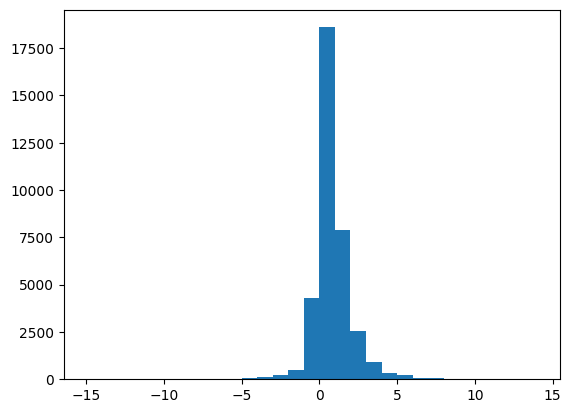

In [21]:
print(len(energies))
plt.hist([x.item() for x in energies], bins=[x for x in range(-15,15)])
plt.show()

# Model - Energy Predictor

In [17]:
class EnergyPredictor(nn.Module):
    def __init__(self, input_size=5, hidden_dim=32):
        super(EnergyPredictor, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_dim, 2, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.parameters())

    def forward(self, steps):
        out, (hidden, _) = self.rnn(steps)
        out = self.fc(out)
        last_timestep = out[:,-1] # Only keep the last output (that output is based on all the particles in the trajectory combined, instead of a subset thereof)
        return last_timestep
model = EnergyPredictor().to(device)

# Training

In [18]:
import time

class Trainer():
    def __init__(self, epochs, batch_size):
        self.epochs = epochs
        self.batch_size = batch_size

    def train(self, dataloader):
        model.train()
        losses = []
        for (y_true, trajectory_batch) in tqdm(dataloader):
            
            model.optimizer.zero_grad()
            
            y_pred = model(trajectory_batch)
            
            loss = model.criterion(y_pred, y_true)
            losses.append(loss.item())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            model.optimizer.step()
                
        return np.array(losses).mean()

    def evaluate(self, dataloader):
        model.eval()
        losses = []
        with torch.no_grad():
            for idx, (y_true, trajectory_batch) in enumerate(dataloader):
                y_pred = model(trajectory_batch)
                loss = model.criterion(y_pred, y_true)
                losses.append(loss.item())

        return np.array(losses).mean()
    
    def run_trainer(self):
        train_loss, val_loss = [], []
        for epoch in range(1, self.epochs + 1):
            epoch_start_time = time.time()
            train_dataloader = DataLoader(dataset=train_task1, batch_size=self.batch_size, collate_fn=collate_batch)
            test_dataloader = DataLoader(dataset=test_task1, batch_size=self.batch_size, collate_fn=collate_batch)
            train_loss.append(self.train(train_dataloader))
            val_loss.append(self.evaluate(test_dataloader))
            
            print('-' * 59)
            print('| end of epoch {:3d} | time: {:5.2f}s | ' 'train loss {:8.3f} valid loss {:8.3f}'.format(epoch, time.time() - epoch_start_time, train_loss[-1], val_loss[-1]))
            print('-' * 59)

In [19]:
# hyperparameters
EPOCHS = 10 # epoch
BATCH_SIZE = 128 # batch size for training/validation

trainer = Trainer(EPOCHS, BATCH_SIZE)
trainer.run_trainer()

  0%|          | 0/282 [00:00<?, ?it/s]c:\Users\20203755\envs\dataScience\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 97%|█████████▋| 273/282 [00:03<00:00, 80.70it/s]c:\Users\20203755\envs\dataScience\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 282/282 [00:03<00:00, 81.11it/s]


-----------------------------------------------------------
| end of epoch   1 | time:  3.69s | train loss    3.639 valid loss    1.448
-----------------------------------------------------------


100%|██████████| 282/282 [00:03<00:00, 83.56it/s]


-----------------------------------------------------------
| end of epoch   2 | time:  3.59s | train loss    3.604 valid loss    1.430
-----------------------------------------------------------


100%|██████████| 282/282 [00:03<00:00, 81.14it/s]


-----------------------------------------------------------
| end of epoch   3 | time:  3.68s | train loss    3.604 valid loss    1.432
-----------------------------------------------------------


100%|██████████| 282/282 [00:03<00:00, 82.42it/s]


-----------------------------------------------------------
| end of epoch   4 | time:  3.60s | train loss    3.602 valid loss    1.431
-----------------------------------------------------------


100%|██████████| 282/282 [00:03<00:00, 80.15it/s]


-----------------------------------------------------------
| end of epoch   5 | time:  3.74s | train loss    3.599 valid loss    1.431
-----------------------------------------------------------


100%|██████████| 282/282 [00:03<00:00, 81.35it/s]


-----------------------------------------------------------
| end of epoch   6 | time:  3.67s | train loss    3.598 valid loss    1.431
-----------------------------------------------------------


100%|██████████| 282/282 [00:03<00:00, 79.31it/s]


-----------------------------------------------------------
| end of epoch   7 | time:  3.77s | train loss    3.598 valid loss    1.431
-----------------------------------------------------------


100%|██████████| 282/282 [00:03<00:00, 73.55it/s]


-----------------------------------------------------------
| end of epoch   8 | time:  4.05s | train loss    3.597 valid loss    1.430
-----------------------------------------------------------


100%|██████████| 282/282 [00:03<00:00, 78.46it/s]


-----------------------------------------------------------
| end of epoch   9 | time:  3.82s | train loss    3.597 valid loss    1.429
-----------------------------------------------------------


100%|██████████| 282/282 [00:04<00:00, 63.46it/s]


-----------------------------------------------------------
| end of epoch  10 | time:  4.75s | train loss    3.596 valid loss    1.428
-----------------------------------------------------------


# Visualize

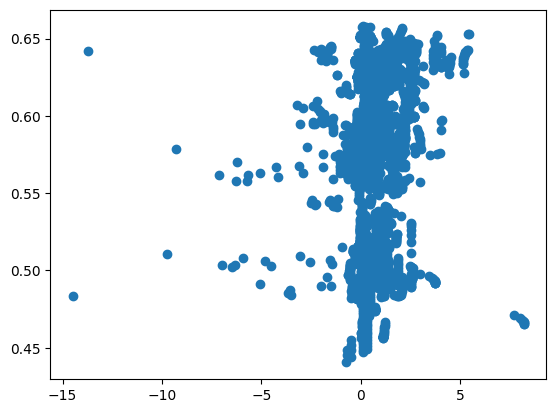

In [20]:
# ...
test_dataloader = DataLoader(dataset=test_task1, batch_size=1, collate_fn=collate_batch)
predict = []
true = []
def evaluate(dataloader):
    model.eval()
    losses = []
    with torch.no_grad():
        for idx, (y_true, trajectory_batch) in enumerate(dataloader):
            y_pred = model(trajectory_batch)
            true.append(y_true)
            predict.append(y_pred)
            # print(y_pred, y_true)
evaluate(test_dataloader)
plt.scatter(true, predict)
plt.show()

# Task 2

Implement task 2 below. Feel free to add extra code cells for different components of your implementation.

# Create Dataset

In [350]:
class TrajectoryDataset(Dataset):
    def __init__(self, train=True):
        type = "train" if train else "test"
        trajectories = []
        files = list(filter(lambda file: ".npz" in file ,os.listdir('data/task1_2/' + type)))
        for file in tqdm(files):
            trajectory, energy = load_trajectory('data/task1_2/' + type + "/" + file, 'task_1')
            num_particles = trajectory.shape[1]
            for i in range(num_particles):
                trajectories.append(trajectory[:,i])
        self.x = torch.tensor(trajectories, dtype=torch.float32)
        print(self.x.shape)
        self.y = self.x
        self.n_samples = len(trajectories)

    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.n_samples
train_task2 = TrajectoryDataset()
test_task2 = TrajectoryDataset(train=False)

100%|██████████| 900/900 [00:13<00:00, 64.51it/s]


torch.Size([3587, 40, 5])


100%|██████████| 100/100 [00:01<00:00, 64.87it/s]


torch.Size([390, 40, 5])


In [351]:
train_dataloader = DataLoader(dataset=train_task2, batch_size=1)
test_dataloader = DataLoader(dataset=test_task2, batch_size=1)
for idx, (y_true, trajectory_batch) in enumerate(train_dataloader):
    print(idx, y_true, trajectory_batch)
    break

0 tensor([[[ 9.5955e+00,  7.5320e+00,  5.1612e-01, -6.9281e-02, -1.0000e+00],
         [ 9.8588e+00,  7.4987e+00,  5.3647e-01, -6.3824e-02, -1.0000e+00],
         [ 1.0132e+01,  7.4680e+00,  5.5510e-01, -5.8939e-02, -1.0000e+00],
         [ 1.0414e+01,  7.4397e+00,  5.7192e-01, -5.4423e-02, -1.0000e+00],
         [ 1.0703e+01,  7.4136e+00,  5.8697e-01, -5.0101e-02, -1.0000e+00],
         [ 1.1000e+01,  7.3896e+00,  6.0038e-01, -4.5854e-02, -1.0000e+00],
         [ 1.1304e+01,  7.3677e+00,  6.1234e-01, -4.1624e-02, -1.0000e+00],
         [ 1.1612e+01,  7.3480e+00,  6.2306e-01, -3.7415e-02, -1.0000e+00],
         [ 1.1926e+01,  7.3303e+00,  6.3276e-01, -3.3287e-02, -1.0000e+00],
         [ 1.2245e+01,  7.3147e+00,  6.4163e-01, -2.9347e-02, -1.0000e+00],
         [ 1.2568e+01,  7.3009e+00,  6.4984e-01, -2.5737e-02, -1.0000e+00],
         [ 1.2895e+01,  7.2888e+00,  6.5756e-01, -2.2624e-02, -1.0000e+00],
         [ 1.3225e+01,  7.2782e+00,  6.6489e-01, -2.0204e-02, -1.0000e+00],
         [

# Model - Trajectory Predictor

In [585]:
def shortest_distance(x1, x2):
    x1 = x1%20
    x2 = x2%20
    return min(abs(x1-x2), abs((x1-20)-x2), abs(x1-(x2-20)), abs((x1-20)-(x2-20)))
# print(shortest_distance(5, 19))
def particle_loss(output, target):
    if (len(output) != 5 or len(target) != 5):
        raise Exception("Loss - input size does not math. Got: ", len(output), ", ", len(target))

    return (shortest_distance(output[0], target[0])**2 + shortest_distance(output[1], target[1])**2 + (output[2]-target[2])**2 +(output[3]-target[3])**2 + (output[4]-target[4])**2)/5
def batch_loss(output, target):
    total_loss = 0
    for i in range(len(output)):
        total_loss += particle_loss(output[i], target[i])
    return total_loss / len(output)

In [584]:
class TrajectoryPredictor(nn.Module):
    def __init__(self, input_size=5, hidden_dim=32):
        super(TrajectoryPredictor, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_dim, 2, batch_first=True)
        self.fc = nn.Linear(hidden_dim, input_size)
        self.criterion = batch_loss
        self.optimizer = torch.optim.Adam(self.parameters())

    def forward(self, steps, hidden_state=None):
        out, hidden_state = self.rnn(steps, hidden_state)
        out = self.fc(out)
        # print("out", out[:,:2].shape)
        # last_timestep = out[:,-1] # Only keep the last output (that output is based on all the particles in the trajectory combined, instead of a subset thereof)
        return out, hidden_state
model = TrajectoryPredictor().to(device)

# Trainer

In [596]:
import time

class Trainer():
    def __init__(self, epochs, batch_size):
        self.epochs = epochs
        self.batch_size = batch_size

    def train(self, dataloader):
        pass

    def evaluate(self, dataloader):
        pass
    
    def run_trainer(self, loss_idx=1, max_idx=None):
        seq_len = 40
        teacher_forcing_ratio = 0.5
        train_dataloader = DataLoader(dataset=train_task2, batch_size=1)
        input_data = train_dataloader
        # test_dataloader = DataLoader(dataset=test_task1, batch_size=self.batch_size, collate_fn=collate_batch)
        for epoch in range(self.epochs):
            model.train()
            model.optimizer.zero_grad()
            
            hidden_state = None
            loss = 0
            losses = []
            
            for idx, (y_true, trajectory_batch) in tqdm(enumerate(train_dataloader)):
                # model.train()
                # model.optimizer.zero_grad()
                # hidden_state = None
                # loss = 0
                predictions = []
                for t in range(1, seq_len):  # seq_len is the number of time steps
                    input_t = trajectory_batch.squeeze()[:t]
                    if (t>1):
                        input_t = torch.stack(predictions)
                    output_t, hidden_state = model(input_t.squeeze(1), hidden_state)
                    output_t[...,:2] %= 20
                    predictions.append(output_t[-1].unsqueeze(0))
                loss += model.criterion(output_t.squeeze(1), trajectory_batch.squeeze()[1:].squeeze(1))
                # for t in range(seq_len-1, seq_len):  # seq_len is the number of time steps
                #     # print(trajectory_batch.shape)
                #     input_t = trajectory_batch.squeeze()[:t]
                #     # print("input", input_t.shape)
                #     # print("input", len(input_t))
                #     target_t = trajectory_batch.squeeze()[1:t + 1]
                    
                #     # if t == 1 or torch.rand(1).item() < teacher_forcing_ratio:
                #     #     input_t = trajectory_batch.squeeze()[:t]
                #     # else:
                #     #     input_t = output_t.detach()
                    
                #     output_t, hidden_state = model(input_t.squeeze(1), hidden_state)
                #     # print("pred:", output_t, "true:", target_t)
                #     loss += model.criterion(output_t.squeeze(1), target_t.squeeze(1))
                # print(idx, loss)
                if (idx%loss_idx == 0):
                    model.optimizer.zero_grad()
                    losses.append(loss.item())
                    loss.backward()
                    model.optimizer.step()
                    hidden_state = None
                    loss = 0
                if (max_idx is not None and idx > max_idx):
                    break
            # loss.backward()
            # model.optimizer.step()
            
            print(f'Epoch {epoch+1}/{self.epochs}, Loss: {np.array(losses).mean()}')

In [597]:
# What did I do. Not just use the model above, but I trained the same model multiple times. All with 10 epochs, but somethimes with loss every 100 or 10 times, and with maximum idx break
# Anddd batch_loss

In [598]:
trainer = Trainer(10, 1)
trainer.run_trainer(1, 100) # Fast start
trainer.run_trainer(1, None) # Slow

101it [00:13,  7.51it/s]


Epoch 1/10, Loss: 10.395815767493902


101it [00:13,  7.48it/s]


Epoch 2/10, Loss: 10.32048349812919


101it [00:13,  7.38it/s]


Epoch 3/10, Loss: 10.294125122766868


101it [00:14,  7.16it/s]


Epoch 4/10, Loss: 10.284689102687087


101it [00:14,  7.15it/s]


Epoch 5/10, Loss: 10.281870616417304


101it [00:14,  7.02it/s]


Epoch 6/10, Loss: 10.28146549767139


101it [00:14,  6.94it/s]


Epoch 7/10, Loss: 10.281082224027783


101it [00:14,  7.10it/s]


Epoch 8/10, Loss: 10.281206739299437


101it [00:14,  6.88it/s]


Epoch 9/10, Loss: 10.281555617556853


101it [00:14,  6.77it/s]


Epoch 10/10, Loss: 10.281071464220682


3587it [08:14,  7.26it/s]


Epoch 1/10, Loss: 10.545012121163838


3587it [08:15,  7.24it/s]


Epoch 2/10, Loss: 10.548764442102238


3587it [08:20,  7.17it/s]


Epoch 3/10, Loss: 10.548710019081822


424it [01:00,  6.97it/s]


KeyboardInterrupt: 

In [599]:
class Evaluate():
    def __init__(self, model, test_dataloader):
        self.model = model
        self.dataloader = test_dataloader
        self.limit = None
    def position_loss(self, output, target):
        if (len(output) != 2 or len(target) != 2):
            raise Exception("Loss - input size does not math. Got: ", len(output), ", ", len(target))

        return (shortest_distance(output[0], target[0])**2 + shortest_distance(output[1], target[1])**2)/2
    def evaluate_trajectory(self, trajectory_batch):
        seq_len = 40
        hidden_state = None
        trajectory_pred = []
        output_t = None
        predictions = [trajectory_batch.squeeze()[0].unsqueeze(0)]
        for t in range(1, seq_len):  # seq_len is the number of time steps
            input_t = trajectory_batch.squeeze()[:t]
            if (t>1):
                # input_t = torch.cat([trajectory_batch.squeeze()[0], output_t])
                # input_t = torch.cat((*predictions[:t-1], output_t))
                input_t = torch.stack(predictions)
            # print("input", input_t)
            # target_t = trajectory_batch.squeeze()[1:t + 1]
            # print("input", input_t)
            output_t, hidden_state = self.model(input_t.squeeze(1), hidden_state)
            output_t[...,:2] %= 20
            predictions.append(output_t[-1].unsqueeze(0))
            # print("output", output_t, ":::", torch.cat(output_t[...,:2]%20, output_t[...,2:]))
            # print("output", output_t, ":::")
            # print(f"t: {t} loss: {self.position_loss(output_t[-1][:2].detach(), trajectory_batch.squeeze()[t][:2])}, y_true {output_t[-1][:2].detach()}, second: {trajectory_batch.squeeze()[t][:2]}")
            trajectory_pred.append([output_t[-1][:2].detach(), trajectory_batch.squeeze()[t][:2]])
        return trajectory_pred

    def evaluate(self):
        losses = []
        model.eval()
        with torch.no_grad():
            for idx, (y_t, trajectory_batch) in tqdm(enumerate(self.dataloader)):
                trajectory_pred = self.evaluate_trajectory(trajectory_batch)
                y_pred = trajectory_pred[-1][0]
                y_true = trajectory_pred[-1][1]
                # print(f"y_true {y_true}, second: {trajectory_batch[-1][-1][:2]}")
                losses.append(self.position_loss(y_pred, y_true))
                if (self.limit is not None and idx>self.limit):
                    break
        return losses
    def evaluate_linear_baseline(self, trajectory_batch):
        seq_len = 40
        trajectory_pred = []
        # print(trajectory_batch.squeeze()[0])
        x0 = trajectory_batch.squeeze()[0][:2]
        v0 = trajectory_batch.squeeze()[0][2:4]
        for t in range(1, seq_len):  # seq_len is the number of time steps
            trajectory_pred.append([(x0 + (v0 * t))%20, trajectory_batch.squeeze()[t][:2]])
        return trajectory_pred
    def linear_baseline(self):
        losses = []
        for idx, (y_t, trajectory_batch) in tqdm(enumerate(self.dataloader)):
            x0 = trajectory_batch[-1][0][:2]
            v0 = trajectory_batch[-1][0][2:4]
            y_pred = x0 + (v0 * 39)
            y_pred %= 20
            y_true = trajectory_batch[-1][-1][:2]
            losses.append(self.position_loss(y_pred, y_true))
            if (self.limit is not None and idx>self.limit):
                    break
        return losses
    def constant_baseline(self):
        losses = []
        for idx, (y_t, trajectory_batch) in tqdm(enumerate(self.dataloader)):
            x0 = trajectory_batch[-1][0][:2]
            y_true = trajectory_batch[-1][-1][:2]
            losses.append(self.position_loss(x0, y_true))
            if (self.limit is not None and idx>self.limit):
                    break
        return losses
        
test_dataloader = DataLoader(dataset=test_task2, batch_size=1)        
evaluater = Evaluate(model, test_dataloader)
            

In [515]:
evaluater.evaluate()

1it [00:00,  5.40it/s]

t: 1 loss: 0.018981296569108963, y_true tensor([ 8.9006, 14.7569]), second: tensor([ 9.0098, 14.5955])
t: 2 loss: 0.03313270956277847, y_true tensor([ 8.7074, 14.9054]), second: tensor([ 8.9146, 14.7526])
t: 3 loss: 0.05936570465564728, y_true tensor([ 8.5475, 15.0114]), second: tensor([ 8.8769, 14.9103])
t: 4 loss: 0.13291418552398682, y_true tensor([ 8.3943, 15.1855]), second: tensor([ 8.8959, 15.0660])
t: 5 loss: 0.2761880159378052, y_true tensor([ 8.2357, 15.3623]), second: tensor([ 8.9649, 15.2183])
t: 6 loss: 0.5277100205421448, y_true tensor([ 8.0665, 15.5662]), second: tensor([ 9.0744, 15.3671])
t: 7 loss: 0.9122394323348999, y_true tensor([ 7.8922, 15.7846]), second: tensor([ 9.2154, 15.5131])
t: 8 loss: 1.4596893787384033, y_true tensor([ 7.7110, 16.0209]), second: tensor([ 9.3804, 15.6571])
t: 9 loss: 2.188563823699951, y_true tensor([ 7.5258, 16.2723]), second: tensor([ 9.5640, 15.7998])
t: 10 loss: 3.1157217025756836, y_true tensor([ 7.3378, 16.5381]), second: tensor([ 9.7

[tensor(24.9354), tensor(6.3519)]

In [600]:
losses_linear_baseline = evaluater.linear_baseline()
losses_constant_baseline = evaluater.constant_baseline()
losses_model = evaluater.evaluate()


390it [00:00, 2499.20it/s]
390it [00:00, 3164.66it/s]
390it [00:12, 32.39it/s]


# Visualize

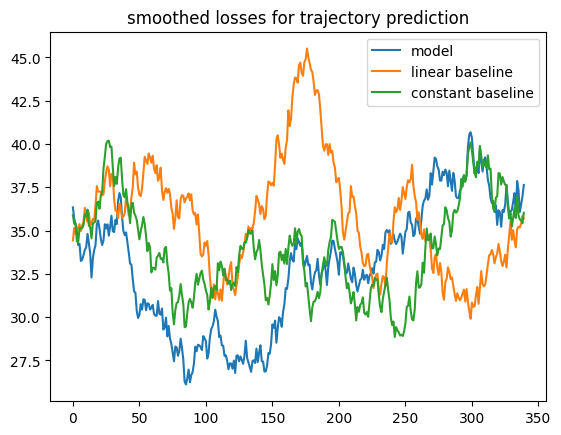

In [601]:
def smooth_losses(losses, sliding_window=50, jumping=False):
    result = []
    for i in range(len(losses)-sliding_window):
        result.append(np.array(losses[i:i+sliding_window]).mean())
    return result

def plot_losses(losses):
    for loss in losses:
        plt.plot(range(len(loss[-1])), loss[-1], label=loss[0])
    plt.title("smoothed losses for trajectory prediction")
    plt.legend()
    plt.show()

plot_losses([["model", smooth_losses(losses_model)], ["linear baseline", smooth_losses(losses_linear_baseline)], ["constant baseline", smooth_losses(losses_constant_baseline)]])

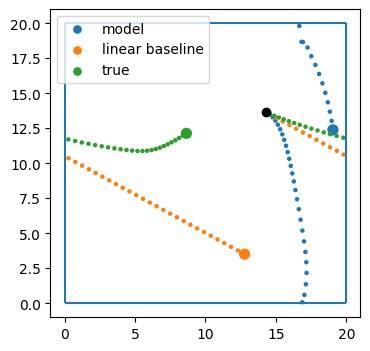

In [551]:
def plot_path(trajectory):
    y_pred = [x[0] for x in trajectory]
    y_true = [x[1] for x in trajectory]
    plt.figure(figsize=(4,4))
    plt.vlines([0,20],0,20)
    plt.hlines([0,20],0,20)

    for traj in [y_pred, y_true]:
        plt.scatter([x[0] for x in traj], [x[1] for x in traj], s=5)

    plt.scatter(y_true[0][0], y_true[0][1], c='black')
    plt.scatter(y_true[-1][0], y_true[-1][1], c='green')
    plt.scatter(y_pred[-1][0], y_pred[-1][1], c='red')
    plt.xlim(-1,21)
    plt.ylim(-1,21)
def plot_paths(trajectories):
    y_preds = [[x[0] for x in trajectory[1]] for trajectory in trajectories]
    y_true = [x[1] for x in trajectories[0][1]]
    labels = [*[trajectory[0] for trajectory in trajectories], "true"]
    plt.figure(figsize=(4,4))
    plt.vlines([0,20],0,20)
    plt.hlines([0,20],0,20)

    for idx, traj in enumerate([*y_preds, y_true]):
        sizes = [*[5 for _ in range(len(traj)-1)], 50] # Last point bigger
        plt.scatter([x[0] for x in traj], [x[1] for x in traj], s=sizes, label=labels[idx])

    plt.scatter(y_true[0][0], y_true[0][1], c='black') # Indicate starter point
    plt.legend()
    plt.xlim(-1,21)
    plt.ylim(-1,21)
def plot_predictions(index=1):
    linear_baseline = evaluater.evaluate_linear_baseline(test_task2.__getitem__(index)[0])
    model = evaluater.evaluate_trajectory(test_task2.__getitem__(index)[0])
    plot_paths([["model", model], ["linear baseline", linear_baseline]])
plot_predictions(297)

# Task 3

In task 3, you also need to model the influences of the crystal. An example of loading a trajectory can be found below. The trajectory and energy data has the same shape as before, however, data regarding the crystal has been added. Since atoms belonging to the crystal do not move, this data does not have a time dimension when loaded. The shapes of the arrays are as follows:

```trajectory```: ```(time, n_bodies, [x, y, v_x, v_y, q])```

```energy```: ```(time, 1)```

```framework```:```(n_framework_atom, [x, y, q])```



In [5]:
trajectory, framework, energy = load_trajectory('data/task3/train/trajectory_0.npz', 'task_3')
print(f'Trajectory shape: {trajectory.shape}, Framework shape: {framework.shape}, Energy shape: {energy.shape}')

Trajectory shape: (40, 4, 5), Framework shape: (20, 3), Energy shape: (40, 1)


The following code provides an example of how to visualize a trajectory with a crystal. Feel free to modify this code, or write your own function. When evaluating your model in this task, keep in mind that you are only allowed to use the data at t=0 (the black dots in the visualization).

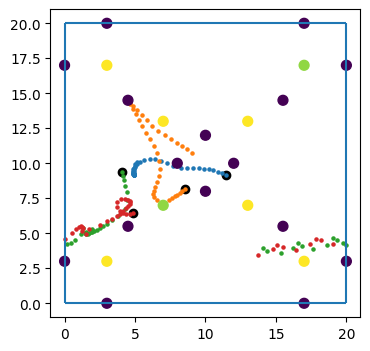

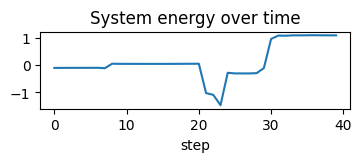

In [6]:
x = trajectory[...,0]
y = trajectory[...,1]

x_fw = framework[...,0]
y_fw = framework[...,1]
q_fw = framework[...,2]

plt.figure(figsize=(4,4))
plt.vlines([0,20],0,20)
plt.hlines([0,20],0,20)

plt.scatter(x[0], y[0], c='black')

for i in range(x.shape[1]):
    plt.scatter(x[:,i], y[:,i], s=5)

plt.scatter(x_fw, y_fw, c=q_fw, cmap='viridis', s=50)
# to also visualize the framework points along the boundaries
plt.scatter(x_fw+20, y_fw, c=q_fw, cmap='viridis', s=50)
plt.scatter(x_fw, y_fw+20, c=q_fw, cmap='viridis', s=50)
plt.scatter(x_fw+20, y_fw+20, c=q_fw, cmap='viridis', s=50)

plt.xlim(-1,21)
plt.ylim(-1,21)

plt.show()
plt.figure(figsize=(4,1))
plt.plot(energy)
plt.xlabel('step')
plt.title('System energy over time')
plt.show();

Implement task 3 below. Feel free to add extra code cells for different components of your implementation.